Data Science Lab:
Technical Assessment

In [1610]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [1611]:
listings = pd.read_csv('../data/listings_summary.csv')
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 96 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                22552 non-null  int64  
 1   listing_url                       22552 non-null  object 
 2   scrape_id                         22552 non-null  int64  
 3   last_scraped                      22552 non-null  object 
 4   name                              22493 non-null  object 
 5   summary                           21589 non-null  object 
 6   space                             14020 non-null  object 
 7   description                       22349 non-null  object 
 8   experiences_offered               22552 non-null  object 
 9   neighborhood_overview             11540 non-null  object 
 10  notes                             7215 non-null   object 
 11  transit                           13036 non-null  object 
 12  acce

I spot a few entirely null columns. Let's get rid of those, and of other columns with just one value. Let's also get rid of columns that have mostly empty rows.

In [1612]:
listings = listings[[column for column
        in listings.columns
        if len(listings[column].unique()) > 1]]
listings = listings[listings.columns[listings.isna().mean() < 0.6]]
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 80 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                22552 non-null  int64  
 1   listing_url                       22552 non-null  object 
 2   last_scraped                      22552 non-null  object 
 3   name                              22493 non-null  object 
 4   summary                           21589 non-null  object 
 5   space                             14020 non-null  object 
 6   description                       22349 non-null  object 
 7   neighborhood_overview             11540 non-null  object 
 8   transit                           13036 non-null  object 
 9   access                            10837 non-null  object 
 10  interaction                       10406 non-null  object 
 11  house_rules                       11449 non-null  object 
 12  pict

We have gotten rid of 16 columns and downsized our dataset by 2.7MB. But 80 columns is on the way-too-many-dimensions side. Let's inspect the data further. I need to get a better look at all the contents.

In [1613]:
for col in listings.columns:
    column = listings[col]
    print(f'COLUMN NAME {col}:')
    print(f'first rows: \n {column.head()}')
    print(f'unique values:\n {column.unique()}')
    print(f'amount unique vals: \n {len(column.unique())}')
    print(f'% null: \n {(column.isna().sum() / len(listings)).round(2) * 100}%')
    print('\n')

COLUMN NAME id:
first rows: 
 0    2015
1    2695
2    3176
3    3309
4    7071
Name: id, dtype: int64
unique values:
 [    2015     2695     3176 ... 29864272 29866805 29867352]
amount unique vals: 
 22552
% null: 
 0.0%


COLUMN NAME listing_url:
first rows: 
 0    https://www.airbnb.com/rooms/2015
1    https://www.airbnb.com/rooms/2695
2    https://www.airbnb.com/rooms/3176
3    https://www.airbnb.com/rooms/3309
4    https://www.airbnb.com/rooms/7071
Name: listing_url, dtype: object
unique values:
 ['https://www.airbnb.com/rooms/2015' 'https://www.airbnb.com/rooms/2695'
 'https://www.airbnb.com/rooms/3176' ...
 'https://www.airbnb.com/rooms/29864272'
 'https://www.airbnb.com/rooms/29866805'
 'https://www.airbnb.com/rooms/29867352']
amount unique vals: 
 22552
% null: 
 0.0%


COLUMN NAME last_scraped:
first rows: 
 0    2018-11-07
1    2018-11-07
2    2018-11-07
3    2018-11-07
4    2018-11-07
Name: last_scraped, dtype: object
unique values:
 ['2018-11-07' '2018-11-09']
amount uniqu

I'm tossing columns out by eyeballing the dataset: 
- I would love to do an in-depth analysis of the textual columns, but unfortunately NLP is not in the scope of this assessment. Therefore I'm dropping the columns with natural language. 
- I'm also seeing quite a few URLs, but there is no information in there either. I was thinking maybe that it was interesting how many photos were uploaded, but I couldn't access the URLs to investigate.
- There's many location types. I want to keep the cleanest location column. I'll keep the clean (what's in a name) columns 'neighbourhood_cleansed' and 'neighbourhood_group_cleansed', to see which one is the best feature.
- The goal of this assignment is predicting the price. I'm going with the idea that airbnb-hosts could get a indication of what amount is normal when renting out locations. I'm guessing those other prices are mostly based on this price, so I'm going to toss those out.
- 'calculated_host_listings_count', 'host_total_listings_count' are duplicates. host_name is redundant due to host_id

In [1614]:
textual_out = [
    'summary', 'space', 'description', 
    'neighborhood_overview',
    'transit', 'access', 'interaction', 
    'house_rules', 'host_about']
url_out = [
    'listing_url', 'picture_url',
    'host_about', 'host_url', 'host_thumbnail_url',
    'host_picture_url']
location_out = [
    'zipcode', 'host_location',
    'market', 'latitude', 'longitude', 'host_neighbourhood',
    'is_location_exact', 'city', 'street','state', 'neighbourhood', 
    'zipcode', 'smart_location']
pricing_out = [
    'extra_people', 'cleaning_fee', 'security_deposit'
    ]
others_out = [
    'calculated_host_listings_count', 'host_total_listings_count', 'host_name'
    ]

dropouts = textual_out + url_out + location_out + pricing_out + others_out
listings = listings.drop(dropouts, axis = 1)
listings.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 48 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                22552 non-null  int64  
 1   last_scraped                      22552 non-null  object 
 2   name                              22493 non-null  object 
 3   host_id                           22552 non-null  int64  
 4   host_since                        22526 non-null  object 
 5   host_response_time                9658 non-null   object 
 6   host_response_rate                9657 non-null   object 
 7   host_is_superhost                 22526 non-null  object 
 8   host_listings_count               22526 non-null  float64
 9   host_verifications                22552 non-null  object 
 10  host_has_profile_pic              22526 non-null  object 
 11  host_identity_verified            22526 non-null  object 
 12  neig

Let's take care of the dtypes of these columns, so that we can later investigate correlations.

In [1615]:
for col in ['property_type', 'room_type', 'neighbourhood_cleansed', 'host_response_time', 'cancellation_policy']:
    listings[col] = listings[col].astype("category")
listings['host_response_time'] = listings['host_response_time'].cat.add_categories("Unknown").fillna("Unknown")


listings = listings.replace({
  't': 1,
  'f': 0
})

listings['price'] = (listings['price']
.str.replace('$', '')
.str.replace('"', '')
.str.replace(',','')
.astype(float)
.astype(int))

/var/folders/sl/95pqlqy97cg_0m_wgf_y736h0000gn/T/ipykernel_16754/53690100.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  listings['price'] = (listings['price']


In [1616]:
listings['host_response_rate'] = (
    listings['host_response_rate']
    .str.replace('%', '')
    .astype(float)
)    

listings['host_response_rate']


0         96.0
1          NaN
2        100.0
3          NaN
4        100.0
         ...  
22547      NaN
22548     88.0
22549      NaN
22550     90.0
22551      NaN
Name: host_response_rate, Length: 22552, dtype: float64

Now that the price column has the right dtype, I want to see what the distribution is of the prices.

/var/folders/sl/95pqlqy97cg_0m_wgf_y736h0000gn/T/ipykernel_16754/1898487233.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(listings['price'])


<AxesSubplot: xlabel='price', ylabel='Density'>

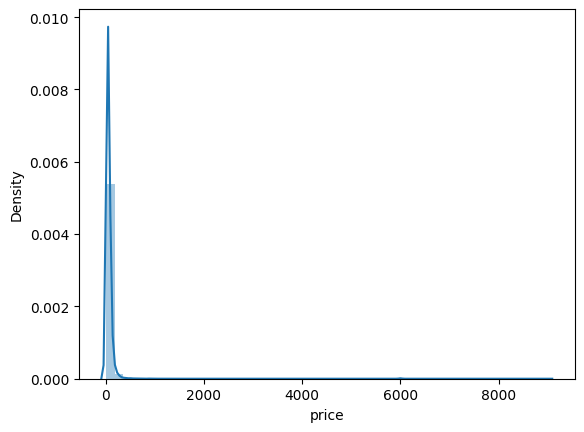

In [1617]:
sns.distplot(listings['price'])

Er, let's inspect further.

In [1618]:
listings['price'].value_counts(bins = 20).sort_values()

(4500.0, 4950.0]        0
(7200.0, 7650.0]        0
(6750.0, 7200.0]        0
(6300.0, 6750.0]        0
(5400.0, 5850.0]        0
(3600.0, 4050.0]        0
(3150.0, 3600.0]        0
(8100.0, 8550.0]        0
(7650.0, 8100.0]        1
(1350.0, 1800.0]        1
(2700.0, 3150.0]        1
(4050.0, 4500.0]        1
(2250.0, 2700.0]        2
(8550.0, 9000.0]        2
(4950.0, 5400.0]        2
(1800.0, 2250.0]        5
(900.0, 1350.0]         7
(5850.0, 6300.0]       20
(450.0, 900.0]         51
(-9.001, 450.0]     22459
Name: price, dtype: int64

I'll get rid of the rows where 'price' is smaller than 1 (Berlin can be verrrry cheap), and set prices larger than 350 to 350.

/var/folders/sl/95pqlqy97cg_0m_wgf_y736h0000gn/T/ipykernel_16754/556717510.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(listings['price'])


<AxesSubplot: xlabel='price', ylabel='Density'>

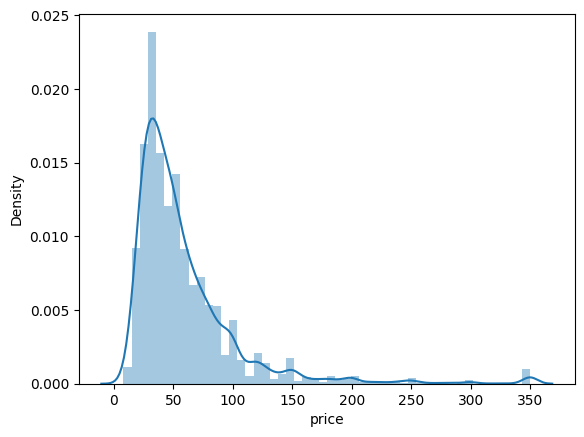

In [1619]:
price_mask = listings['price'] > 1
listings = listings[price_mask]
listings.loc[listings['price'] >= 350, 'price'] = 350
sns.distplot(listings['price'])

Then I'll combine the date columns into something more meaningful: how long someone was a host up until that point. I'm doing the same for first_review and last_review. Combining into a period of receiving reviews

In [1620]:
def new_col_time_calc(new_column_name : str, start_date_column : str, end_date_column: str, dataframe: pd.DataFrame):
    for time_column in [end_date_column, start_date_column]:
        dataframe[time_column] = pd.to_datetime(dataframe[time_column])
    dataframe[new_column_name] = round(((dataframe[end_date_column] - dataframe[start_date_column])/np.timedelta64(1, 'Y')), 2)
    return dataframe.drop([start_date_column, end_date_column], axis=1)

In [1621]:
listings = new_col_time_calc(
    new_column_name = 'hosting_years', 
    start_date_column = 'host_since', 
    end_date_column = 'last_scraped',
    dataframe = listings)

listings = new_col_time_calc(
    new_column_name = 'review_period', 
    start_date_column = 'first_review', 
    end_date_column = 'last_review',
    dataframe = listings)

In [1622]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22543 entries, 0 to 22551
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   id                                22543 non-null  int64   
 1   name                              22484 non-null  object  
 2   host_id                           22543 non-null  int64   
 3   host_response_time                22543 non-null  category
 4   host_response_rate                9655 non-null   float64 
 5   host_is_superhost                 22517 non-null  float64 
 6   host_listings_count               22517 non-null  float64 
 7   host_verifications                22543 non-null  object  
 8   host_has_profile_pic              22517 non-null  float64 
 9   host_identity_verified            22517 non-null  float64 
 10  neighbourhood_cleansed            22543 non-null  category
 11  neighbourhood_group_cleansed      22543 non-null  obje

I'm guessing the more verifications a host has, the better. So let's change 'host_verifications' to a count of their verifications

In [1623]:
list_verifications = list(listings['host_verifications'].str.replace('"', ''))
amt_host_verifications = []
for list_raw in list_verifications:
    amt_host_verifications.append(int(len(list_raw.split(","))))

listings['amt_host_verifications'] = pd.Series(amt_host_verifications)
listings = listings.drop(['host_verifications'], axis=1)

If a listing doesn't have a name it's hardly worth considering.

In [1624]:
listings = listings.dropna(subset = ['name'])

Let's check where we're at.

In [1625]:
for col in listings.columns:
    amt_empty = listings[col].isna().sum()
    if (amt_empty >= 1):
        print(f'{col}: {amt_empty} null values')

host_response_rate: 12832 null values
host_is_superhost: 26 null values
host_listings_count: 26 null values
host_has_profile_pic: 26 null values
host_identity_verified: 26 null values
bathrooms: 32 null values
bedrooms: 17 null values
beds: 40 null values
review_scores_rating: 4362 null values
review_scores_accuracy: 4386 null values
review_scores_cleanliness: 4383 null values
review_scores_checkin: 4404 null values
review_scores_communication: 4391 null values
review_scores_location: 4404 null values
review_scores_value: 4408 null values
reviews_per_month: 3889 null values
hosting_years: 26 null values
review_period: 3889 null values
amt_host_verifications: 9 null values


/var/folders/sl/95pqlqy97cg_0m_wgf_y736h0000gn/T/ipykernel_16754/3346342270.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = listings.corr()


<AxesSubplot: >

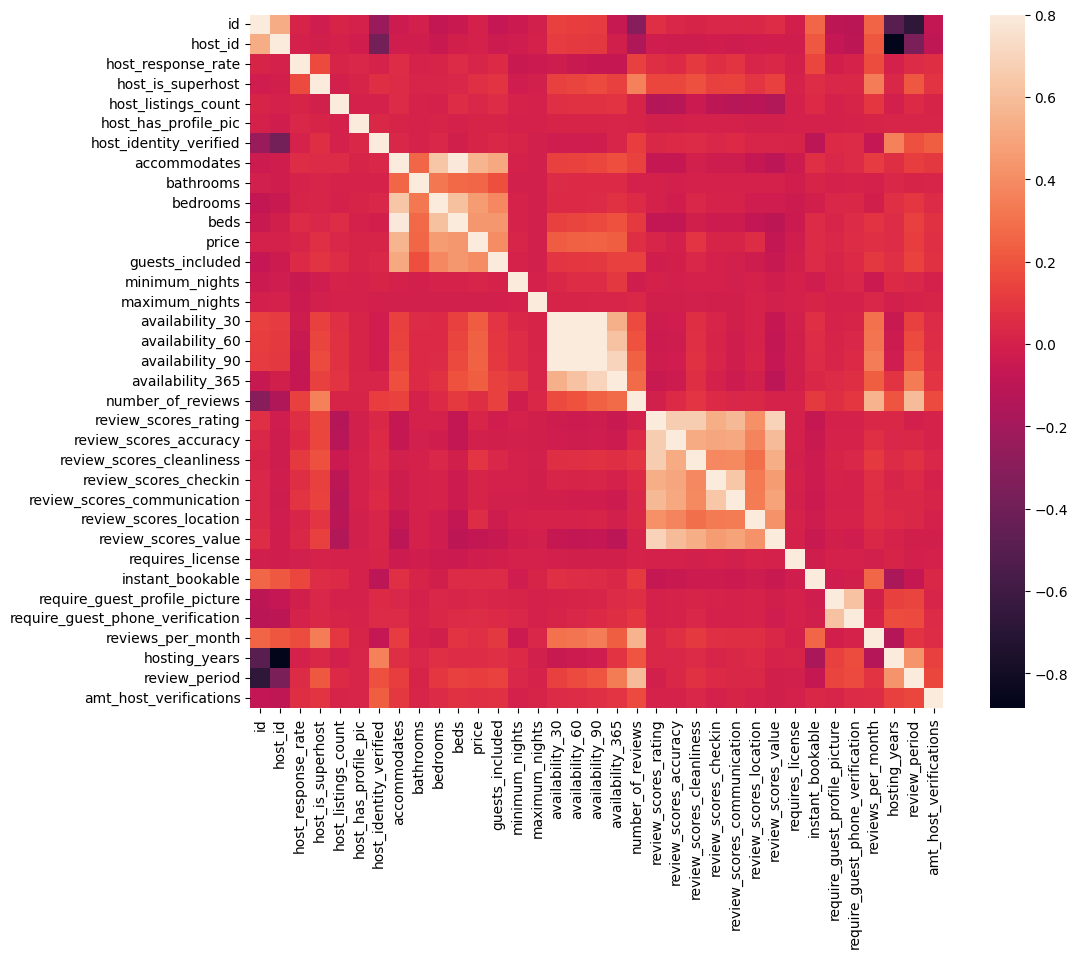

In [1626]:
corrmat = listings.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

Looking at this  of null values list and the correlation matrix:
- There's many review_scores, that are all highly similar. I'll keep the review_scores_rating, which is an average of the rest.
- I'm thinking there might be a lot of airbnb-listings on here that are not active. If a host is not responding, what does that mean?
- host_identity verified: if it's false, amt_host_verifications = 0 and if it's true, then it is at least 1.
- availability_30/60/90/365 have about the same amount of correlations with 'price'. 
I'm dropping the empty beds/bathrooms/bedrooms. Nobody would book these: it's the first thing you enter into airbnb. I'm also dropping reviews_per_month, since it's strongly correlated with number_of_reviews, which is not empty anywhere.
- the review_scores_rating that are null mostly don't have other ratings either. To be sure I'll give them a rating of 50.

In [1627]:
true_mask = (listings['host_identity_verified'] == True)
listings['amt_host_verifications'] = np.where(true_mask, 1, 0)
listings = listings.drop(['host_identity_verified'], axis = 1)

In [1628]:
review_out = ['review_scores_accuracy',
'review_scores_cleanliness', 
'review_scores_checkin',
'review_scores_communication',
'review_scores_location', 'review_scores_value',
'reviews_per_month']
availability_out = ['availability_30', 'availability_60', 'availability_90']
columns_out = review_out + availability_out
listings = listings.drop(columns_out, axis=1)
listings = listings.dropna(subset = ['beds', 'bathrooms', 'bedrooms'])


Let's see where we are

In [1629]:
for col in listings.columns:
    amt_empty = listings[col].isna().sum()
    if (amt_empty >= 1):
        print(f'{col}: {amt_empty} null values')

host_response_rate: 12803 null values
host_is_superhost: 26 null values
host_listings_count: 26 null values
host_has_profile_pic: 26 null values
review_scores_rating: 4331 null values
hosting_years: 26 null values
review_period: 3859 null values


There are 26 null values of a few host-related columns. I can toss those rows out, because there's not enough information on the host. They are probably all the same. Let's see if they all fall out if I get rid of one:

In [1630]:
listings = listings.dropna(subset = ['host_is_superhost'])
for col in listings.columns:
    amt_empty = listings[col].isna().sum()
    if (amt_empty >= 1):
        print(f'{col}: {amt_empty} null values')

host_response_rate: 12777 null values
review_scores_rating: 4318 null values
review_period: 3848 null values


The review period is null for many rows. If there are no reviews recorded, the review period will be 0. If there is just one, then we will assign a review period of 1 (year).

In [1631]:
true_mask = (listings['number_of_reviews'] == 0)
listings['review_period'] = np.where(true_mask, 0, listings['review_period'])

true_mask = (listings['number_of_reviews'] == 1)
listings['review_period'] = np.where(true_mask, 1, listings['review_period'])

listings['review_period'].isna().sum()

10

Let's get rid of the remaining null values!

In [1632]:
listings['review_period'] = listings['review_period'].fillna(listings['hosting_years'])
listings['review_scores_rating'] = listings['review_scores_rating'].fillna(50)
listings['host_response_rate'] = listings['host_response_rate'].fillna(listings['host_response_rate'].mean())

In [1633]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22379 entries, 0 to 22551
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   id                                22379 non-null  int64   
 1   name                              22379 non-null  object  
 2   host_id                           22379 non-null  int64   
 3   host_response_time                22379 non-null  category
 4   host_response_rate                22379 non-null  float64 
 5   host_is_superhost                 22379 non-null  float64 
 6   host_listings_count               22379 non-null  float64 
 7   host_has_profile_pic              22379 non-null  float64 
 8   neighbourhood_cleansed            22379 non-null  category
 9   neighbourhood_group_cleansed      22379 non-null  object  
 10  property_type                     22379 non-null  category
 11  room_type                         22379 non-null  cate

In [1634]:
bools = ['host_is_superhost', 'host_has_profile_pic', 'requires_license',
 'instant_bookable','require_guest_profile_picture',
 'require_guest_phone_verification']
listings[bools] = listings[bools].astype(bool)
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22379 entries, 0 to 22551
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   id                                22379 non-null  int64   
 1   name                              22379 non-null  object  
 2   host_id                           22379 non-null  int64   
 3   host_response_time                22379 non-null  category
 4   host_response_rate                22379 non-null  float64 
 5   host_is_superhost                 22379 non-null  bool    
 6   host_listings_count               22379 non-null  float64 
 7   host_has_profile_pic              22379 non-null  bool    
 8   neighbourhood_cleansed            22379 non-null  category
 9   neighbourhood_group_cleansed      22379 non-null  object  
 10  property_type                     22379 non-null  category
 11  room_type                         22379 non-null  cate

In [1635]:
listings.columns

Index(['id', 'name', 'host_id', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_has_profile_pic',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'guests_included',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'review_scores_rating', 'requires_license', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'hosting_years', 'review_period',
       'amt_host_verifications'],
      dtype='object')

<AxesSubplot: >

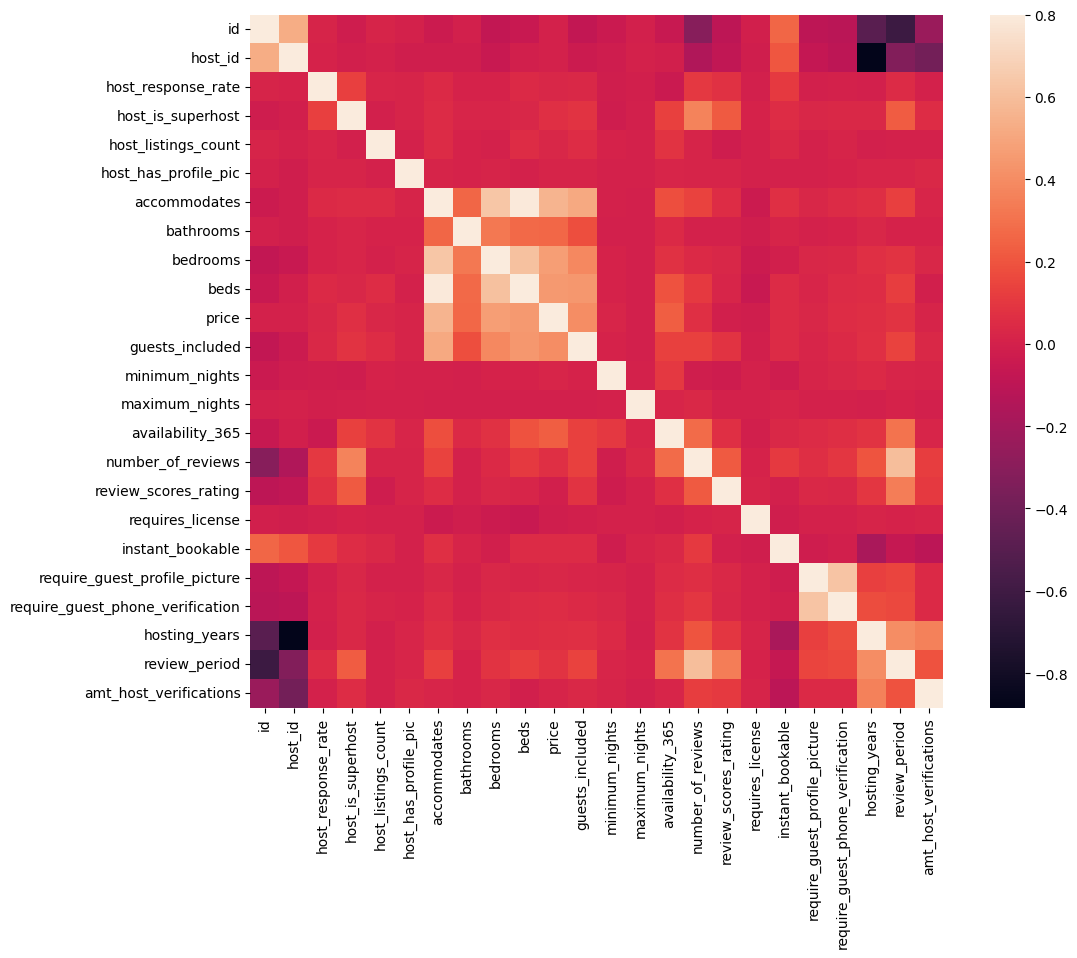

In [1636]:
corrmat = listings.corr(numeric_only= True)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

Let's zoom in on price

In [1637]:
from pandas.api.types import is_numeric_dtype
print('Correlations')
correlations = []
for column in listings.columns:
    if column == 'price':
        continue
    if not(is_numeric_dtype(listings[column])):
        continue
    correlation = listings['price'].corr(listings[column])
    correlations.append((column, correlation))
sorted(correlations,key=lambda tup: tup[1])

Correlations


[('requires_license', -0.01901729410389113),
 ('review_scores_rating', -0.008938097874647246),
 ('maximum_nights', -0.002319537392545394),
 ('host_id', -0.0019748307179176775),
 ('id', 0.0011541571562153161),
 ('amt_host_verifications', 0.013722792035730316),
 ('host_has_profile_pic', 0.01604159728163379),
 ('minimum_nights', 0.02020734842018974),
 ('host_listings_count', 0.02541463279832038),
 ('host_response_rate', 0.026528226321214717),
 ('require_guest_profile_picture', 0.027128502188681743),
 ('instant_bookable', 0.04452892479033514),
 ('require_guest_phone_verification', 0.05520441331615958),
 ('hosting_years', 0.05891610447079576),
 ('number_of_reviews', 0.06413934157707778),
 ('host_is_superhost', 0.06775094389842366),
 ('review_period', 0.07897332904596424),
 ('availability_365', 0.23145888807075166),
 ('bathrooms', 0.2611149816756603),
 ('guests_included', 0.3993637452582967),
 ('beds', 0.44564731660212875),
 ('bedrooms', 0.4670540094769092),
 ('accommodates', 0.5603312112989

I'm thinking that not only the beds/bedrooms/accomodations are interesting - what is further present in the house might also be in-/decreasing the price. So let's look at 'amenities'

In [1638]:
listings['amenities']

0        {TV,"Cable TV",Wifi,Kitchen,Gym,Heating,"Famil...
1        {Wifi,Kitchen,Elevator,Heating,Washer,Essentia...
2        {Internet,Wifi,Kitchen,"Buzzer/wireless interc...
3        {Internet,Wifi,"Pets allowed","Pets live on th...
4        {Wifi,Heating,"Family/kid friendly",Essentials...
                               ...                        
22547    {Wifi,"Smoking allowed",Heating,Essentials,Sha...
22548    {TV,Wifi,Kitchen,"Free parking on premises","F...
22549    {Wifi,Kitchen,Heating,Washer,"Fire extinguishe...
22550    {Wifi,"Paid parking off premises",Doorman,Elev...
22551    {Wifi,"Air conditioning",Kitchen,Breakfast,Hea...
Name: amenities, Length: 22379, dtype: object

In [1639]:
collect_amenities = list(listings['amenities'])
collect_amenities = (" ".join(collect_amenities)
.replace('{', '')
.replace('}', ',')
.replace('"', '')
)
amenities_set = set([x.strip() for x in collect_amenities.split(',')])
amenities_list = list(amenities_set)
amenities_list = amenities_list[1:]

In [1640]:
def add_amenity(amenity):
    listings.loc[listings['amenities'].str.contains(f'{amenity}'), f'{amenity}'] = True
    listings[f'{amenity}'] = listings[f'{amenity}'].fillna(False)

for amenity in amenities_list:
    add_amenity(amenity) 

/var/folders/sl/95pqlqy97cg_0m_wgf_y736h0000gn/T/ipykernel_16754/4074421579.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  listings.loc[listings['amenities'].str.contains(f'{amenity}'), f'{amenity}'] = True
/var/folders/sl/95pqlqy97cg_0m_wgf_y736h0000gn/T/ipykernel_16754/4074421579.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  listings.loc[listings['amenities'].str.contains(f'{amenity}'), f'{amenity}'] = True
/var/folders/sl/95pqlqy97cg_0m_wgf_y736h0000gn/T/ipykernel_16754/4074421579.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  listings.loc[listings['amenities'].st

In [1641]:
def binary_count_and_price_plot(col, figsize=(3,1)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = figsize )
    fig.suptitle(col, fontsize=8, y=1)
    
    listings.groupby(col).size().plot(kind='bar', ax=ax1, color=['red', 'green'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('count')
    ax1.set_xlabel('')
    
    listings.groupby(col)['price'].median().plot(kind='bar', ax=ax2, color=['black', 'blue'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('price')
    ax2.set_xlabel('')
    
    plt.show()

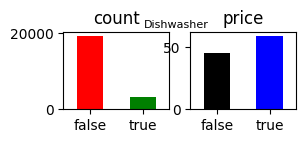

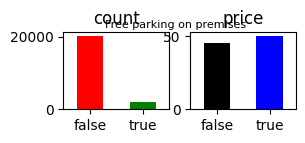

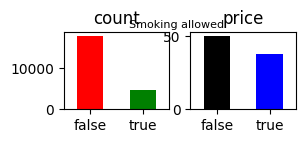

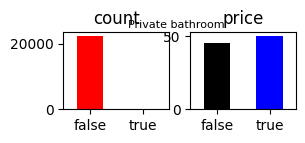

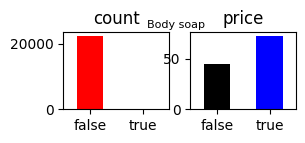

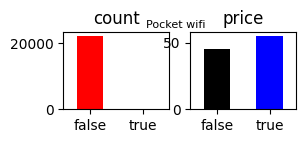

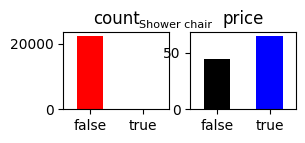

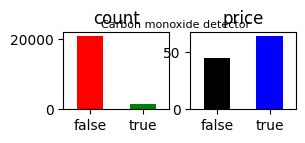

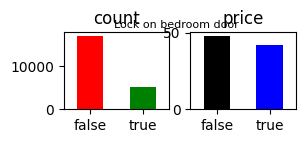

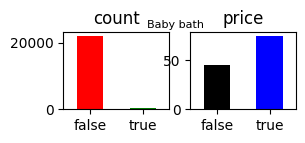

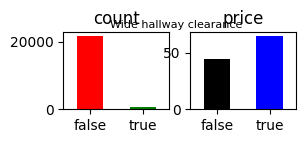

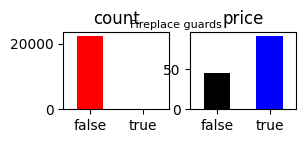

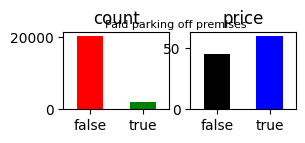

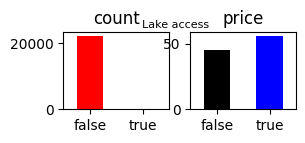

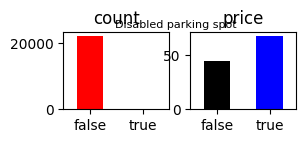

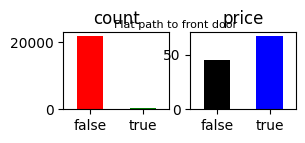

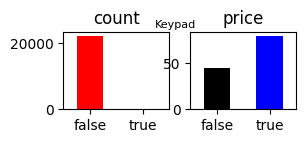

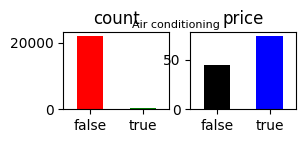

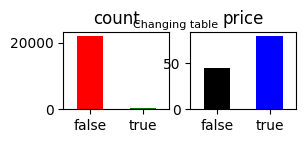

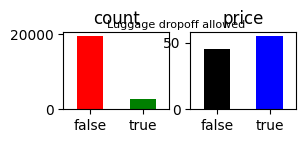

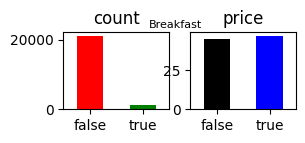

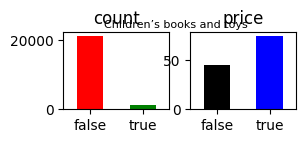

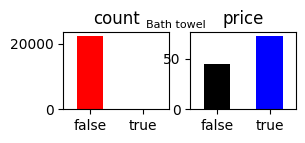

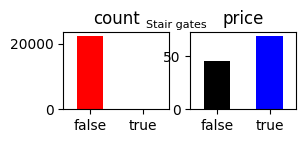

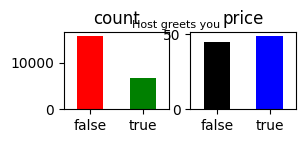

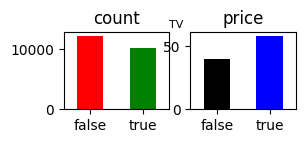

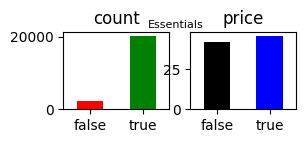

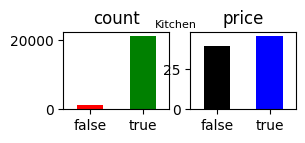

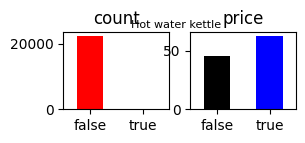

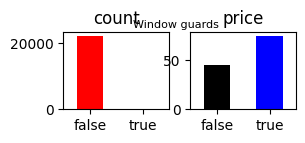

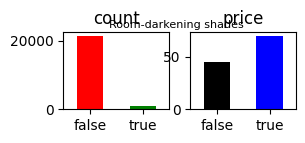

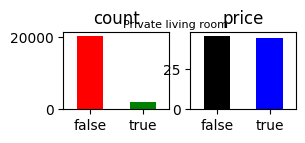

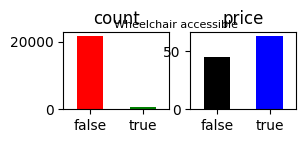

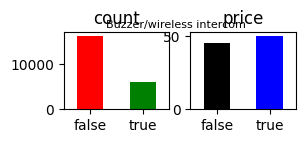

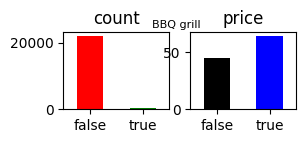

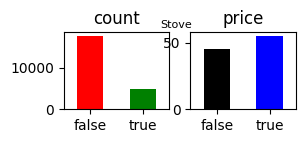

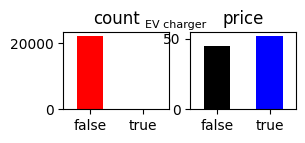

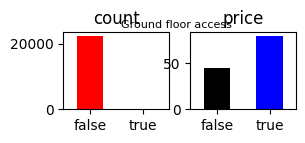

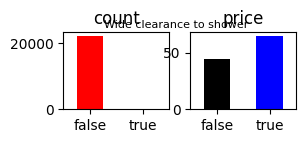

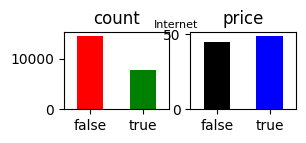

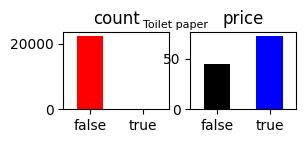

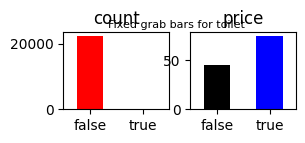

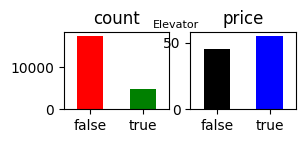

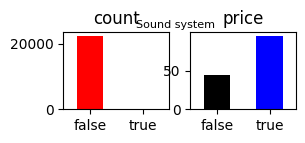

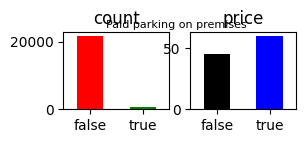

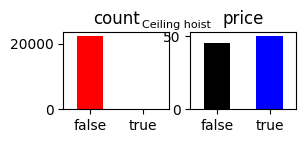

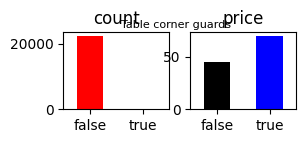

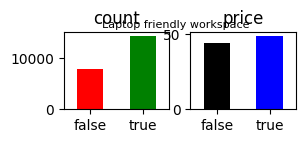

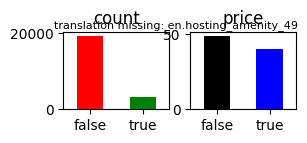

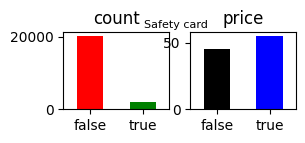

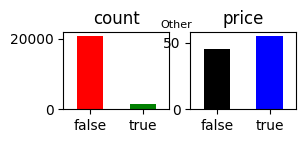

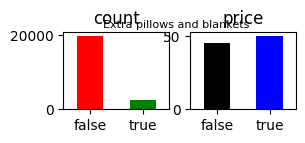

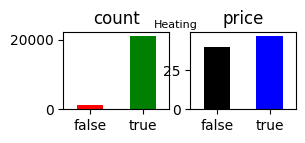

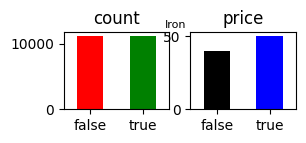

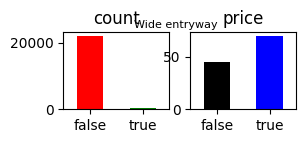

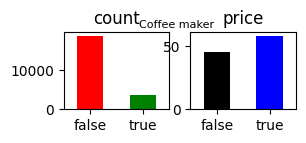

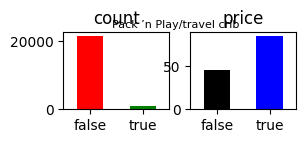

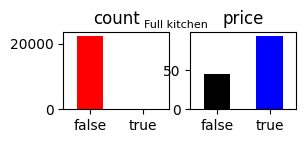

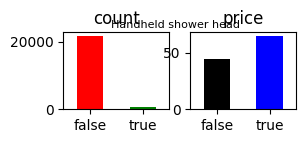

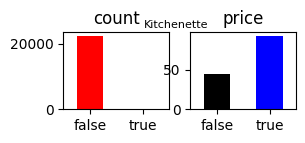

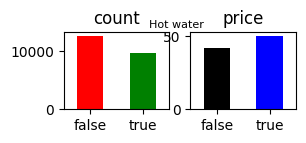

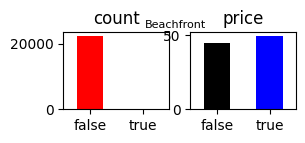

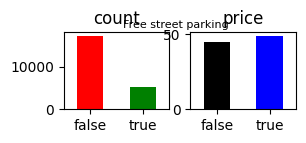

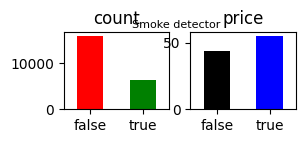

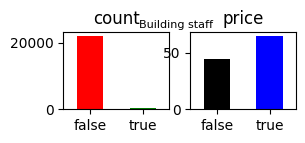

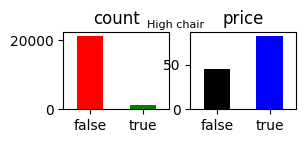

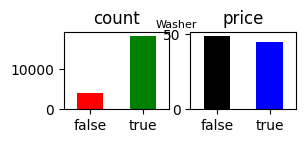

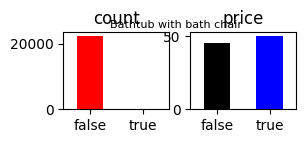

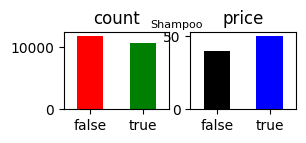

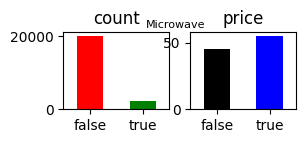

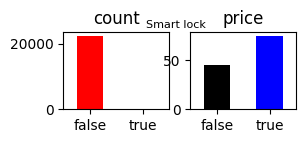

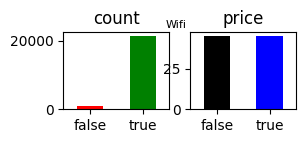

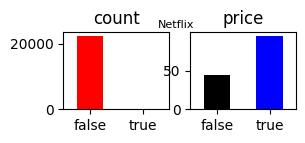

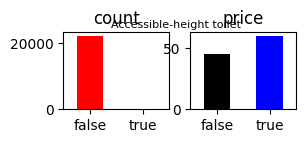

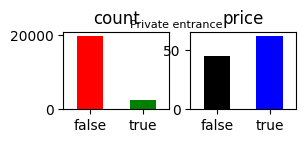

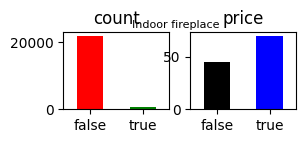

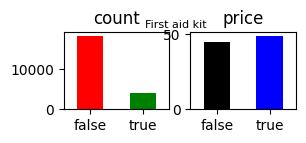

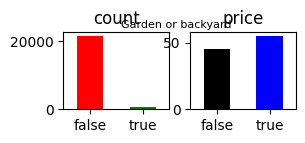

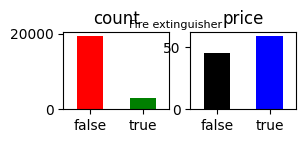

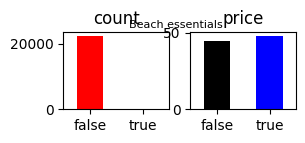

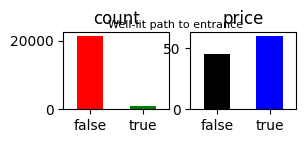

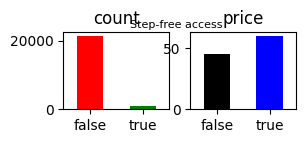

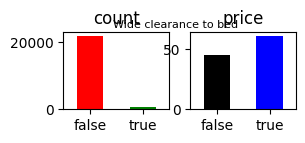

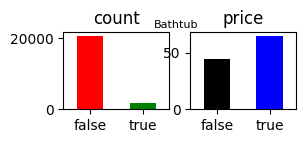

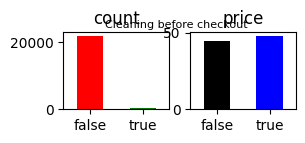

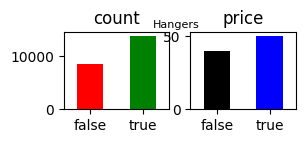

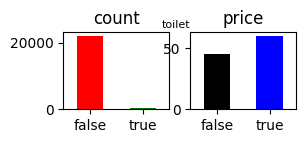

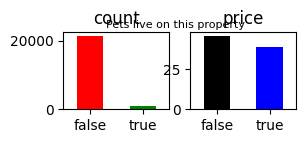

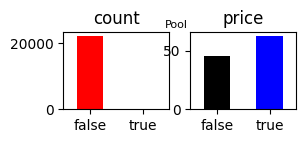

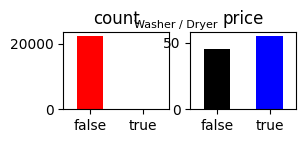

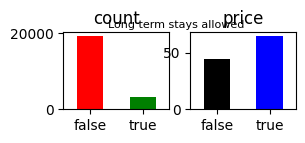

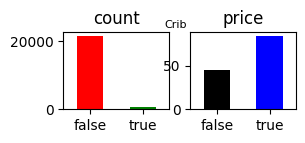

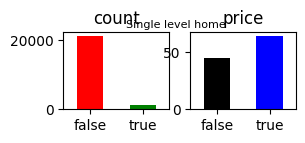

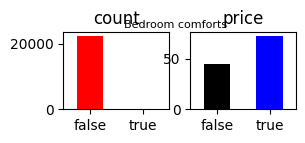

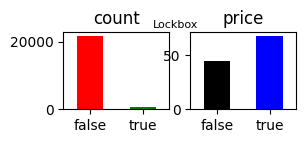

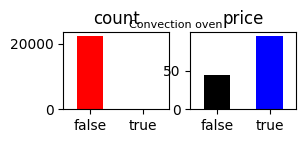

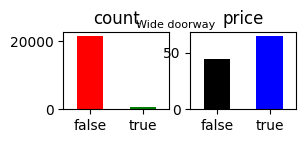

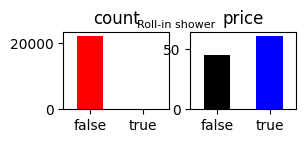

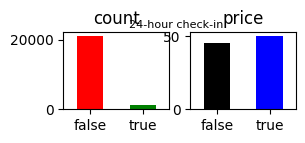

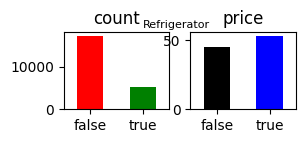

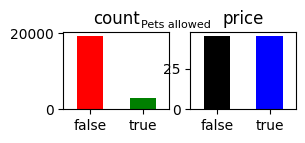

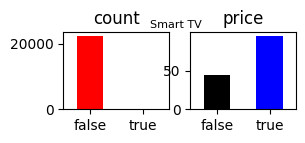

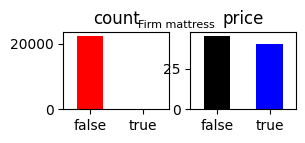

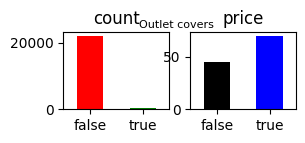

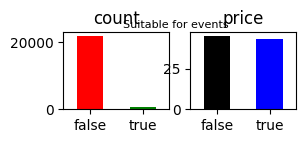

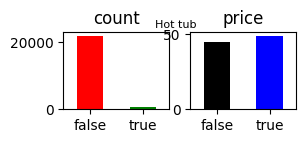

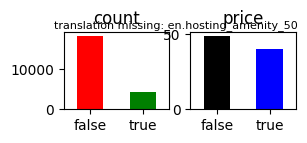

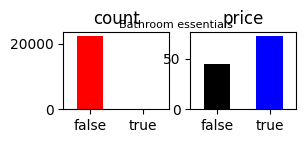

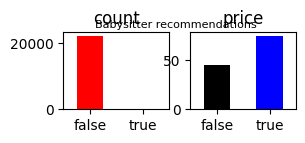

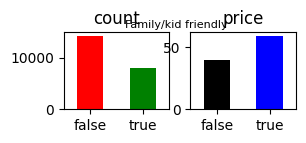

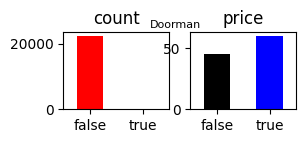

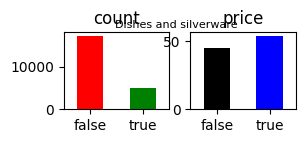

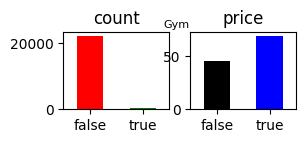

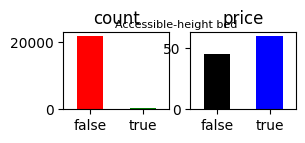

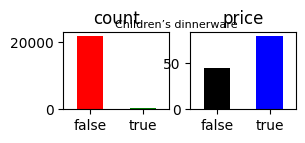

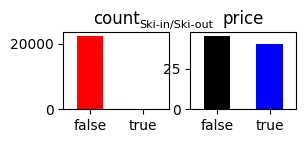

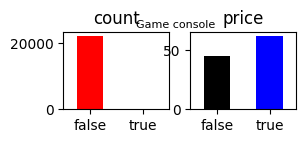

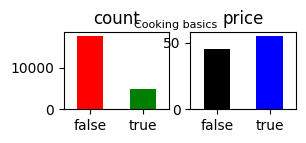

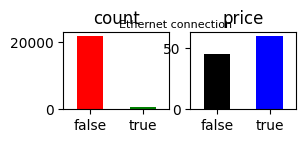

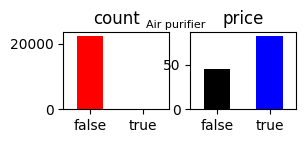

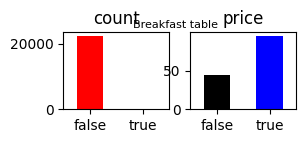

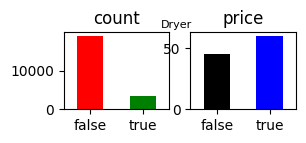

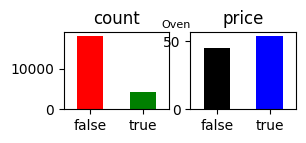

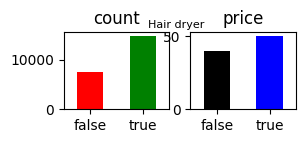

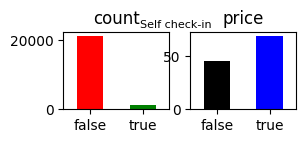

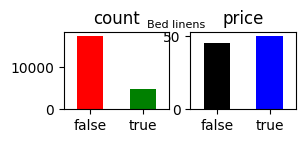

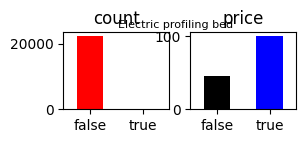

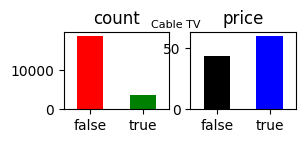

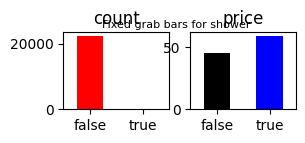

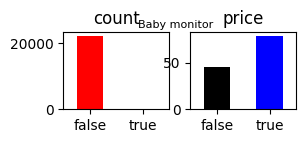

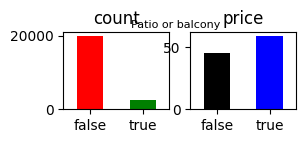

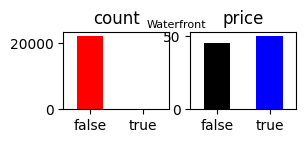

In [1642]:
for x in amenities_list:
    if(not(len(listings[x].unique()) == 2)):
        continue
    binary_count_and_price_plot(x)



Those are not all very informative where there's so many false values. 

In [1643]:
infrequent_amenities = []
for col in amenities_list:
    if listings[col].sum() < len(listings)/10:
        infrequent_amenities.append(col)
listings = listings.drop(infrequent_amenities + ['amenities'], axis=1)


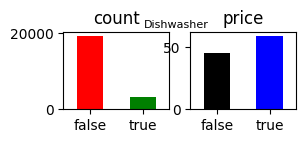

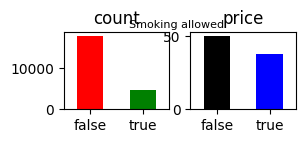

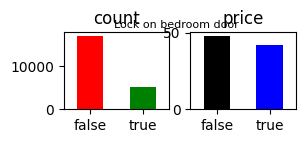

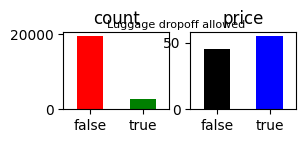

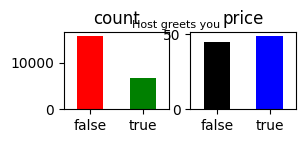

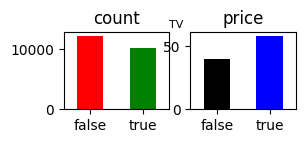

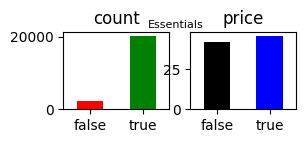

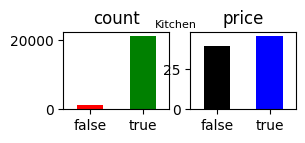

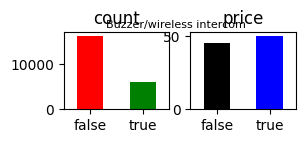

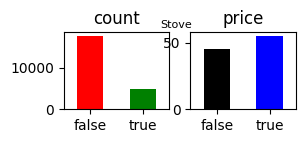

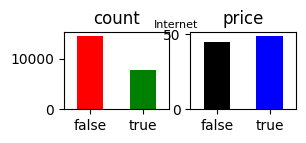

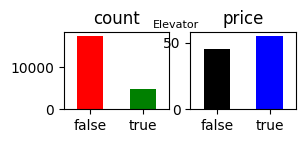

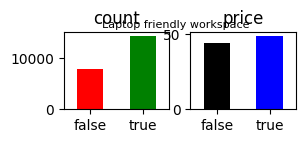

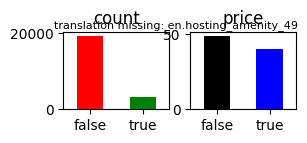

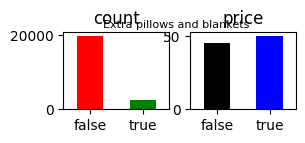

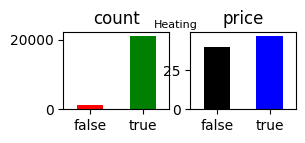

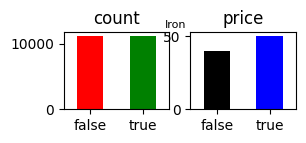

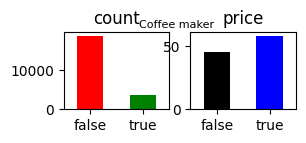

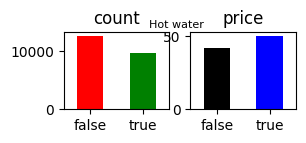

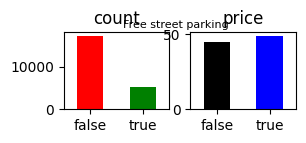

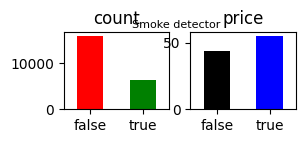

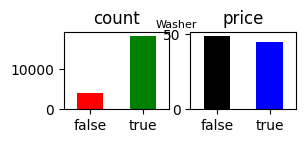

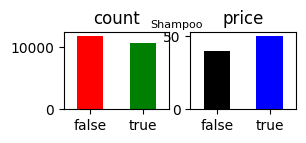

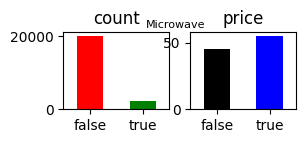

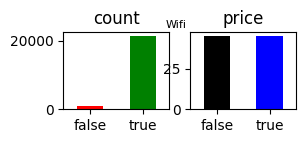

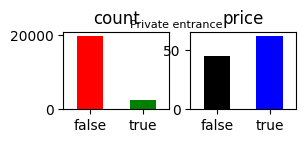

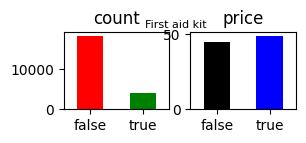

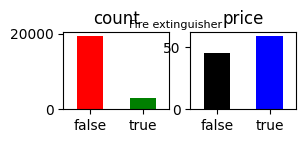

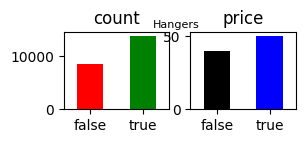

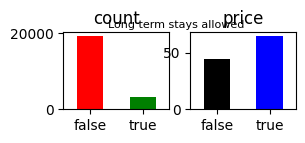

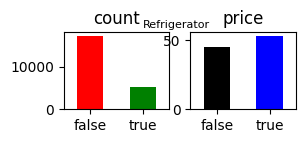

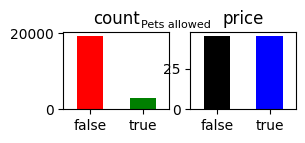

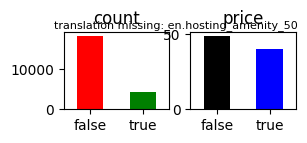

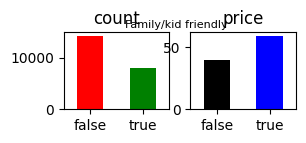

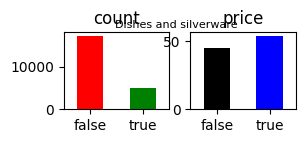

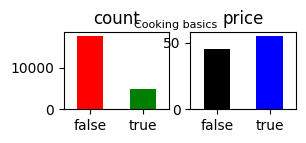

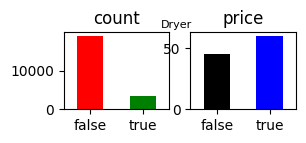

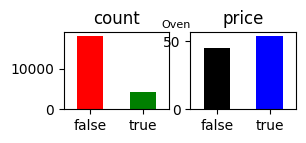

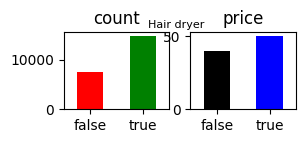

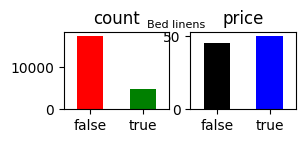

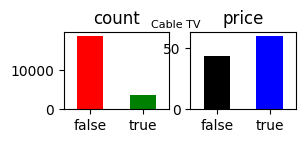

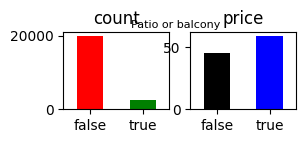

In [1644]:
remaining_amenities = [x for x in amenities_list if (x not in infrequent_amenities)]
for x in remaining_amenities:
    if(not(len(listings[x].unique()) == 2)):
        continue
    binary_count_and_price_plot(x)

In [1645]:
rename_amenities = dict([(x, x.lower().replace(' ', '_')) for x in remaining_amenities])
listings = listings.rename(rename_amenities, axis='columns')

In [1646]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22379 entries, 0 to 22551
Data columns (total 76 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   id                                          22379 non-null  int64   
 1   name                                        22379 non-null  object  
 2   host_id                                     22379 non-null  int64   
 3   host_response_time                          22379 non-null  category
 4   host_response_rate                          22379 non-null  float64 
 5   host_is_superhost                           22379 non-null  bool    
 6   host_listings_count                         22379 non-null  float64 
 7   host_has_profile_pic                        22379 non-null  bool    
 8   neighbourhood_cleansed                      22379 non-null  category
 9   neighbourhood_group_cleansed                22379 non-null  object  
 10

One last thing: I'll remove duplicates in name/host_id, then drop the name column since it's textual. Then I'll save it and use that dataset to do the feature selection!

I'll also remove some more columns.

In [1647]:
listings = listings.drop_duplicates(subset = ['name', 'host_id'], keep = 'first')
listings = listings.drop(['calendar_updated', 'calendar_last_scraped'], axis=1)

In [1648]:
listings.to_csv('../data/preprocessed.csv')